In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from inventory import Inventory, engine_efficiency_projection, electricity_emission_factor_2030
from Constants import Constants
import numpy as np
from pathlib import Path

# 2011 bazni inventar

In [4]:
root_dir = Path('..')

/home/dionizije/Documents/vk_secap/src/inventory.py:460: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 6))


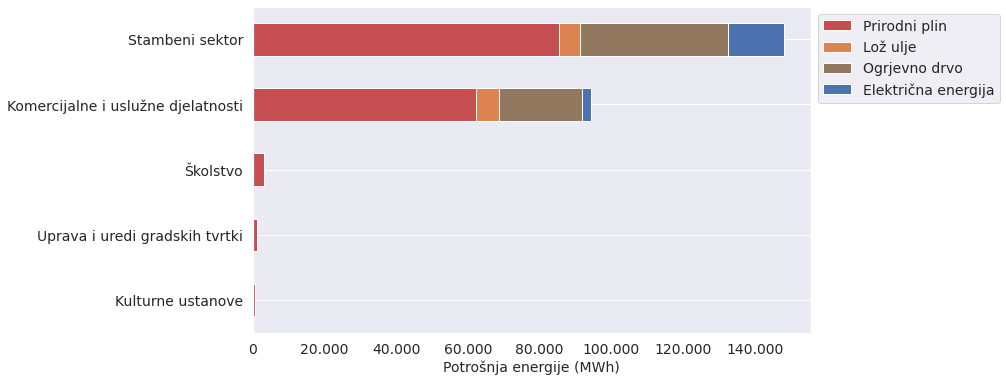

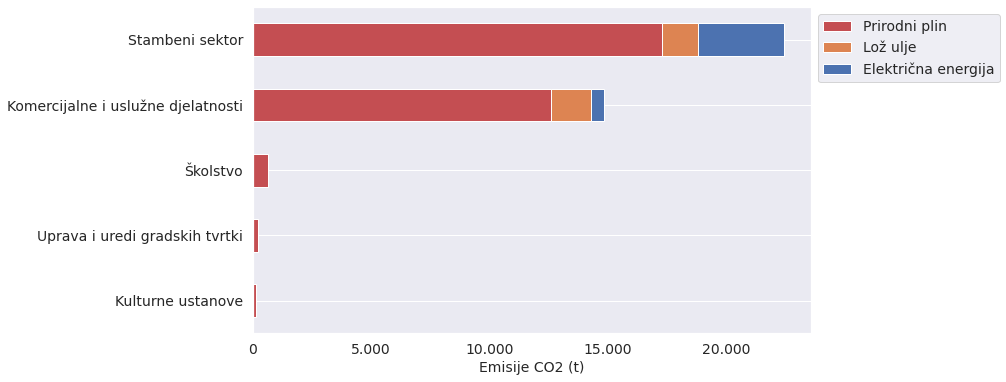

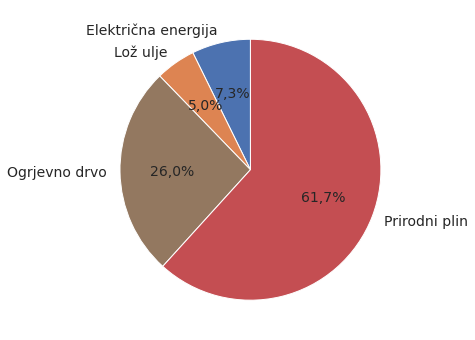

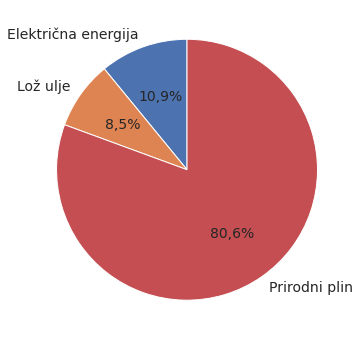

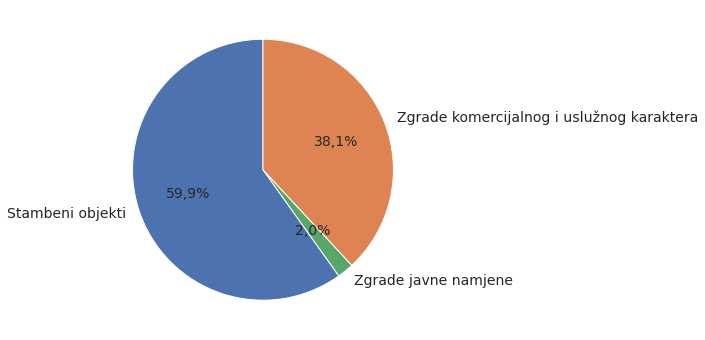

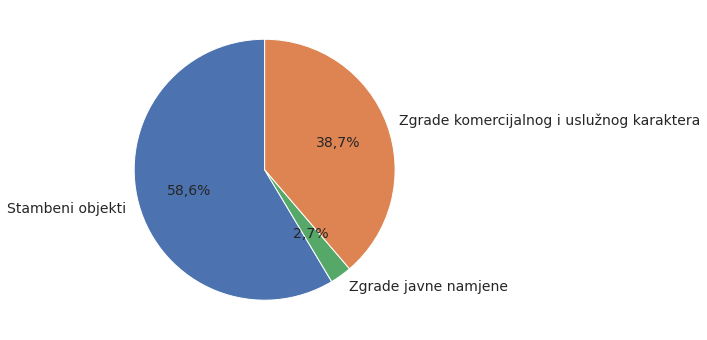

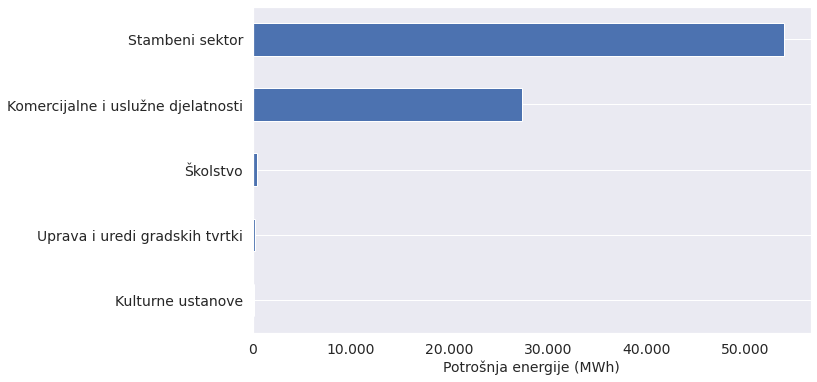

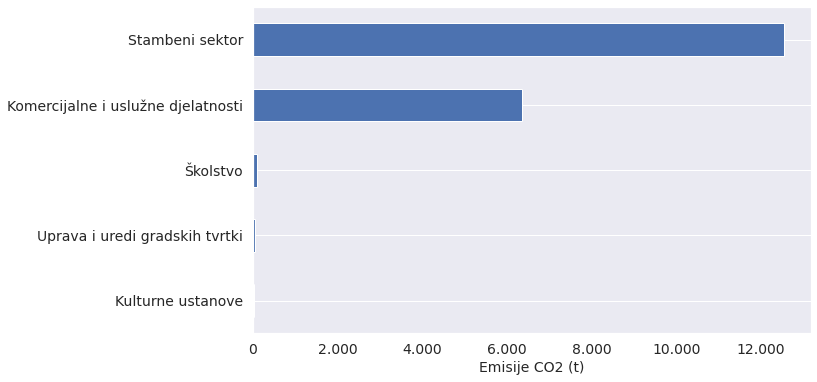

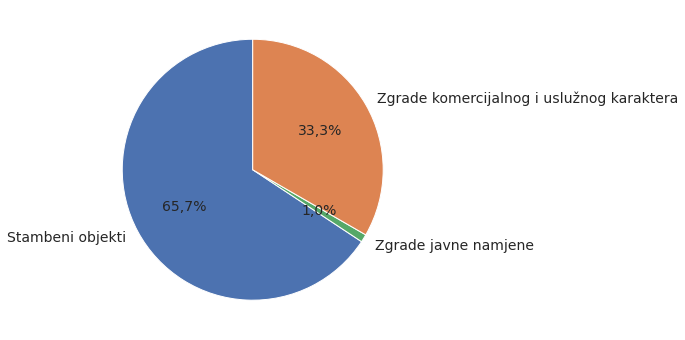

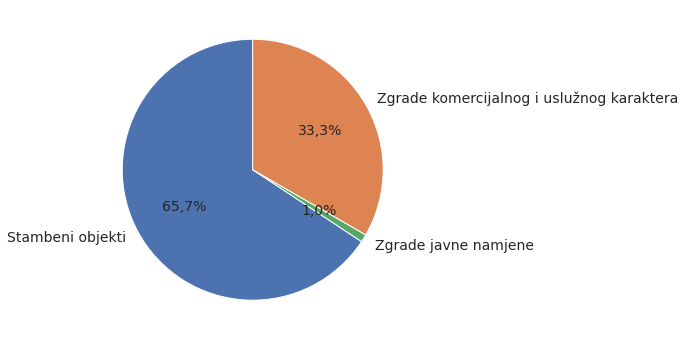

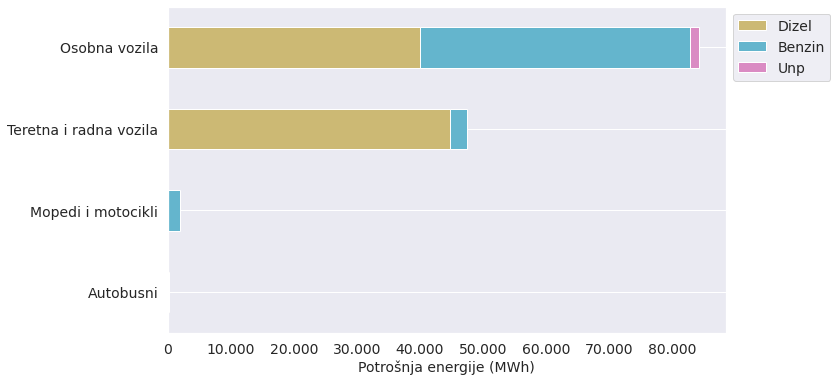

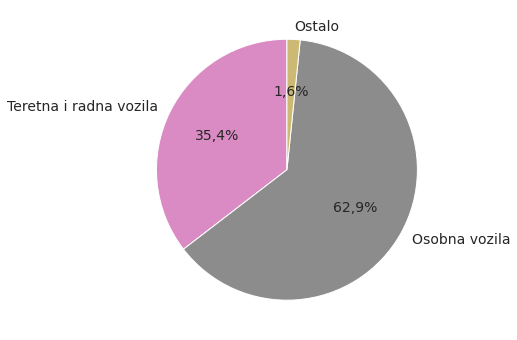

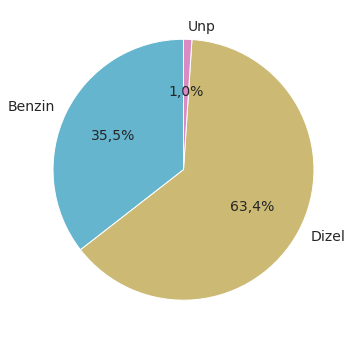

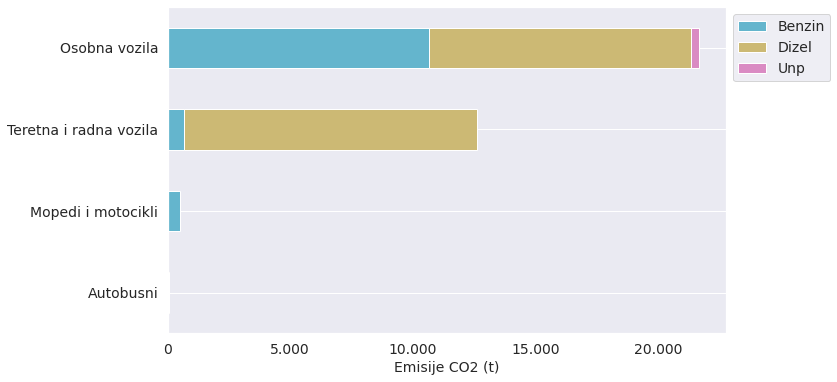

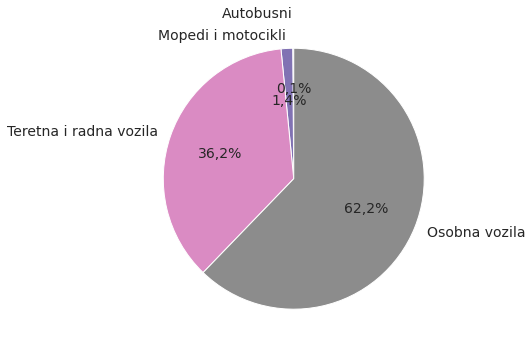

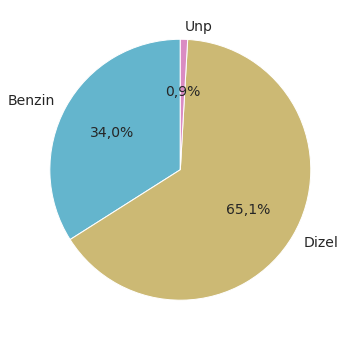

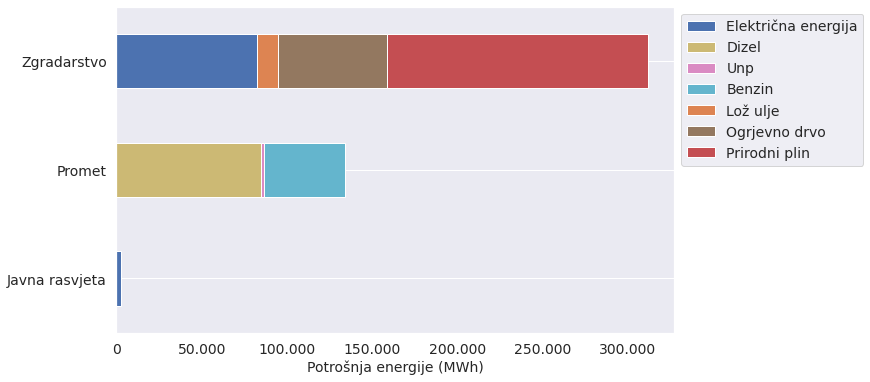

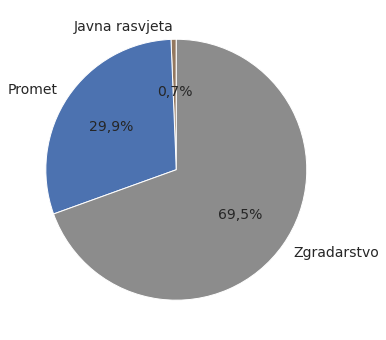

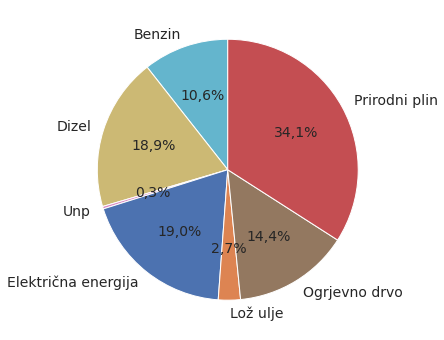

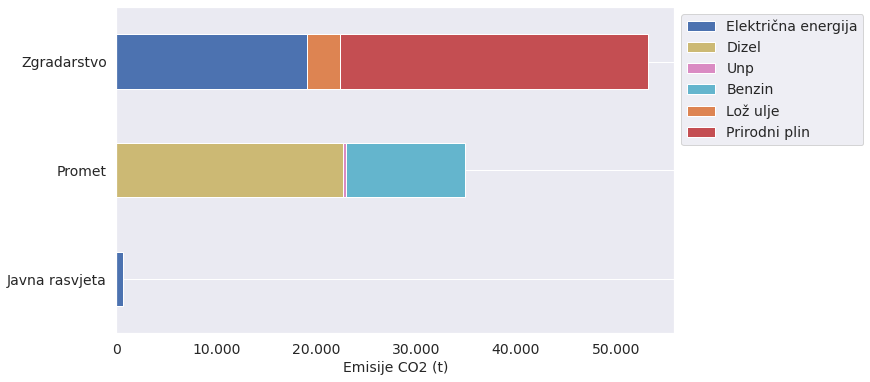

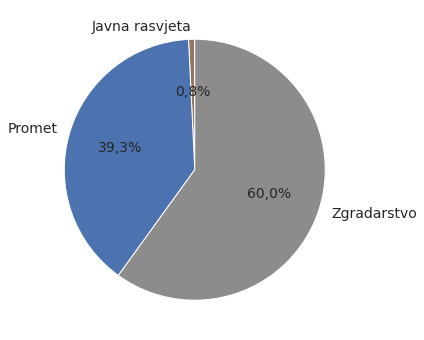

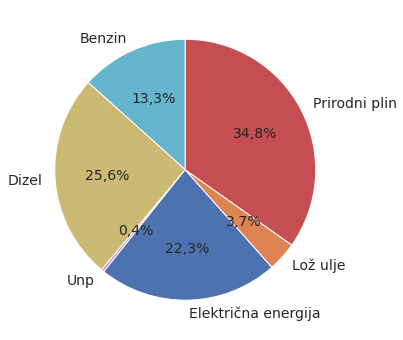

In [5]:
constants = Constants()
# 2011
output_dir = root_dir / 'output/2011/'
heat = pd.read_csv(root_dir / 'data/2011/vinkovci_grijanje_2011.csv')
ele = pd.read_csv(root_dir / 'data/2011/vinkovci_struja_2011.csv')
trans = pd.read_csv(root_dir / 'data/2011/privatna_vozila_2011.csv')
light = ['električna energija', 2922.5, 678.0, 'javna rasvjeta']

# fuel consumption is 2011 is too low, adjust to the same calculation as in 2019
km_per_vehicle = 12542 # same km per year per vehicle
factor = constants.specific_consumption_petrol_2000 / constants.specific_consumption_diesel_2000 # how much more petrol is spent
# adjust the fuel to get proportions
petrol_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
                 'procijenjena_potrošena_masa_benzina(t)'] / factor
lpg_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_unp(t)'] / factor
diesel_adj = trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila']['procijenjena_potrošena_masa_dizela(t)']
total = petrol_adj + lpg_adj + diesel_adj

prop_petrol = petrol_adj / total
prop_lpg = lpg_adj / total
prop_diesel = diesel_adj / total

# calculate tons of fuel
diesel_spent = prop_diesel * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * constants.diesel_km_per_year * constants.specific_consumption_diesel_2000 * constants.diesel_litre_to_ton
petrol_spent = prop_petrol * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * constants.petrol_km_per_year * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton
lpg_spent = prop_lpg * trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila'][
    'broj'] * constants.unp_km_per_year * constants.specific_consumption_petrol_2000 * constants.lpg_petrol_index * constants.lpg_litre_to_ton

# fix values for cars
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_dizela(t)'] = diesel_spent
trans.loc[trans['vrsta_prijevoza'] == 'osobna vozila', 'procijenjena_potrošena_masa_unp(t)'] = lpg_spent

# fix values for trucks
petrol_adj = trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
                 'procijenjena_potrošena_masa_benzina(t)'] / factor
diesel_adj = trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila']['procijenjena_potrošena_masa_dizela(t)']
total = petrol_adj + diesel_adj

prop_petrol = petrol_adj / total
prop_diesel = diesel_adj / total

diesel_spent = prop_diesel * trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
    'broj'] * constants.heavy_km_per_year * constants.specific_consumption_diesel_2000 * constants.diesel_litre_to_ton
petrol_spent = prop_petrol * trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila'][
    'broj'] * constants.heavy_km_per_year * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton

trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent
trans.loc[trans['vrsta_prijevoza'] == 'teretna i radna vozila', 'procijenjena_potrošena_masa_dizela(t)'] = diesel_spent

# fix values for bikes
petrol_spent = trans.loc[trans['vrsta_prijevoza'] == 'mopedi i motocikli'][
    'broj'] * constants.bikes_km_per_year * constants.specific_consumption_petrol_2000 * constants.petrol_litre_to_ton
trans.loc[
    trans['vrsta_prijevoza'] == 'mopedi i motocikli', 'procijenjena_potrošena_masa_benzina(t)'] = petrol_spent


# group heat to fit 2019 format
heat['kategorija'] = heat['kategorija'].replace('objekti i uredi gradskih tvrtki', 'uprava i uredi gradskih tvrtki')
heat['kategorija'] = heat['kategorija'].replace('uprava', 'uprava i uredi gradskih tvrtki')
heat = heat.groupby(['nadkategorija', 'kategorija', 'energent'], as_index=False).sum()

# group electricity to fit 2019 format
ele['kategorija'] = ele['kategorija'].replace('objekti i uredi gradskih tvrtki', 'uprava i uredi gradskih tvrtki')
ele['kategorija'] = ele['kategorija'].replace('uprava', 'uprava i uredi gradskih tvrtki')
ele = ele.groupby(['nadkategorija', 'kategorija'], as_index=False).sum()

base_inventory_2011 = Inventory(constants, 2011)
inventory_2011 = base_inventory_2011.base_inventory(output_dir, heat, ele, trans, light)

In [6]:
inventory_2011.keys()

dict_keys(['heat', 'heat_co2', 'electricity', 'electricity_co2', 'transport', 'transport_co2', 'total', 'total_co2'])

## Potrošnja topline u zgradarstvu

* Tablica 1 po energentu

In [7]:
inventory_2011['heat']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
kulturne ustanove,657.7,63.3,0.0,0.0
uprava i uredi gradskih tvrtki,1066.9,0.0,0.0,37.8
školstvo,3219.4,15.3,0.0,0.0
komercijalne i uslužne djelatnosti,62307.6,6441.3,23188.6,2340.4
stambeni sektor,85563.1,5760.0,41250.8,15646.1


In [8]:
inventory_2011['heat'].sum()

energent
prirodni plin         152814.7
lož ulje               12279.8
ogrjevno drvo          64439.4
električna energija    18024.4
dtype: float64

In [9]:
inventory_2011['heat'].sum().sum()

247558.33119

* Tablica 1 po sektoru

In [10]:
inventory_2011['heat'].sum(axis=1)

kategorija
kulturne ustanove                       720.9
uprava i uredi gradskih tvrtki         1104.7
školstvo                               3234.7
komercijalne i uslužne djelatnosti    94277.9
stambeni sektor                      148220.0
dtype: float64

In [11]:
inventory_2011['heat'].sum(axis=1).sum()

247558.33119

## Emisije CO2 toplinske energije u sektoru zgradarstva

* Tablica 2 po energentu

In [12]:
inventory_2011['heat_co2']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
kulturne ustanove,132.9,16.7,0.0,0.0
uprava i uredi gradskih tvrtki,215.5,0.0,0.0,8.8
školstvo,650.3,4.0,0.0,0.0
komercijalne i uslužne djelatnosti,12586.1,1700.5,0.0,543.7
stambeni sektor,17283.7,1520.6,0.0,3634.9


In [13]:
inventory_2011['heat_co2'].sum()

energent
prirodni plin         30868.6
lož ulje               3241.9
ogrjevno drvo             0.0
električna energija    4187.4
dtype: float64

* Tablica 2 po sektoru

In [14]:
inventory_2011['heat_co2'].sum(axis=1)

kategorija
kulturne ustanove                      149.6
uprava i uredi gradskih tvrtki         224.3
školstvo                               654.4
komercijalne i uslužne djelatnosti   14830.4
stambeni sektor                      22439.3
dtype: float64

In [15]:
inventory_2011['heat_co2'].sum(axis=1).sum()

38297.86441327803

## Potrošnja struje

In [16]:
inventory_2011['electricity']

kategorija
kulturne ustanove                      125.7
uprava i uredi gradskih tvrtki         220.3
školstvo                               455.9
komercijalne i uslužne djelatnosti   27390.0
stambeni sektor                      54014.0
Name: potrošnja_energije(MWh), dtype: float64

In [17]:
inventory_2011['electricity'].sum()

82205.917

## Emisije CO2 iz potrošnje struje

In [18]:
inventory_2011['electricity_co2']

kategorija
kulturne ustanove                       29.2
uprava i uredi gradskih tvrtki          51.2
školstvo                               105.9
komercijalne i uslužne djelatnosti    6363.2
stambeni sektor                      12548.5
Name: Emisije CO2 (t), dtype: float64

In [19]:
inventory_2011['electricity_co2'].sum()

19098.05893842394

## Potrošnja u prometu

In [20]:
trans

,vrsta_prijevoza,broj,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t)
0,autobusni,6,nan,13.9,nan
1,taxi,1,nan,1.6,nan
2,osobna vozila,10005,3486.9,3365.2,105.4
3,teretna i radna vozila,2102,217.6,3762.8,nan
4,mopedi i motocikli,910,163.6,nan,nan


In [21]:
trans.sum()

vrsta_prijevoza                           autobusnitaxiosobna vozilateretna i radna vozi...
broj                                                                                  13024
procijenjena_potrošena_masa_benzina(t)                                               3868.0
procijenjena_potrošena_masa_dizela(t)                                                7143.5
procijenjena_potrošena_masa_unp(t)                                                    105.4
dtype: object

* U MWh

In [22]:
inventory_2011['transport'].sum(axis=1)

vrsta_prijevoza
autobusni                  165.4
mopedi i motocikli        2012.0
teretna i radna vozila   47453.8
osobna vozila            84315.0
dtype: float64

In [23]:
inventory_2011['transport'].sum(axis=1).sum()

133946.12157006646

## Potrošnja CO2 u prometu

In [24]:
inventory_2011.keys()

dict_keys(['heat', 'heat_co2', 'electricity', 'electricity_co2', 'transport', 'transport_co2', 'total', 'total_co2'])

In [25]:
inventory_2011['transport_co2']

energent,Benzin,Dizel,UNP
vrsta_prijevoza,,,
autobusni,0.0,44.2,0.0
mopedi i motocikli,501.0,0.0,0.0
teretna i radna vozila,666.3,11955.7,0.0
osobna vozila,10679.2,10692.1,313.5


In [26]:
inventory_2011['transport_co2'].sum()

energent
Benzin   11846.5
Dizel    22691.9
UNP        313.5
dtype: float64

In [27]:
inventory_2011['transport_co2'].sum(axis=1)

vrsta_prijevoza
autobusni                   44.2
mopedi i motocikli         501.0
teretna i radna vozila   12622.0
osobna vozila            21684.9
dtype: float64

In [28]:
inventory_2011['transport_co2'].sum(axis=1).sum()

34851.9910813887

## Ukupna potrošnja

In [29]:
inventory_2011['total'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,2922.5,0.0,82205.9
Dizel,0.0,84988.6,0.0
UNP,0.0,1381.3,0.0
Benzin,0.0,47576.3,0.0
lož ulje,0.0,0.0,12279.8
ogrjevno drvo,0.0,0.0,64439.4
prirodni plin,0.0,0.0,152814.7


In [30]:
inventory_2011['total'].T.sum()

sektor
javna rasvjeta     2922.5
promet           133946.1
zgradarstvo      311739.9
dtype: float64

In [31]:
inventory_2011['total'].T.sum().sum()

448608.5017600665

In [32]:
inventory_2011['total'].sum()

energent
električna energija    85128.4
Dizel                  84988.6
UNP                     1381.3
Benzin                 47576.3
lož ulje               12279.8
ogrjevno drvo          64439.4
prirodni plin         152814.7
dtype: float64

## Ukupne emisije CO2

In [33]:
inventory_2011['total_co2'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,678.0,0.0,19098.1
Dizel,0.0,22691.9,0.0
UNP,0.0,313.5,0.0
Benzin,0.0,11846.5,0.0
lož ulje,0.0,0.0,3241.9
prirodni plin,0.0,0.0,30868.6


In [34]:
inventory_2011['total_co2'].T.sum()

sektor
javna rasvjeta     678.0
promet           34852.0
zgradarstvo      53208.5
dtype: float64

In [35]:
inventory_2011['total_co2'].T.sum().sum()

88738.49757851264

In [36]:
inventory_2011['total_co2'].sum()

energent
električna energija   19776.1
Dizel                 22691.9
UNP                     313.5
Benzin                11846.5
lož ulje               3241.9
prirodni plin         30868.6
dtype: float64

# 2019 inventar

/home/dionizije/Documents/vk_secap/src/inventory.py:460: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10, 6))


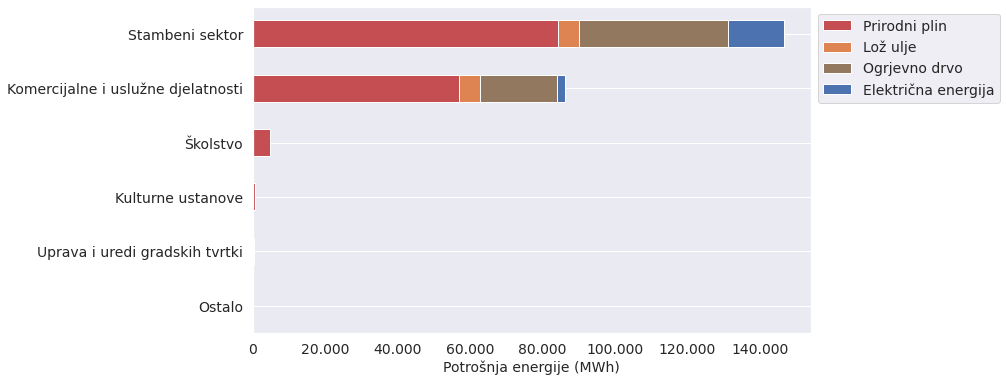

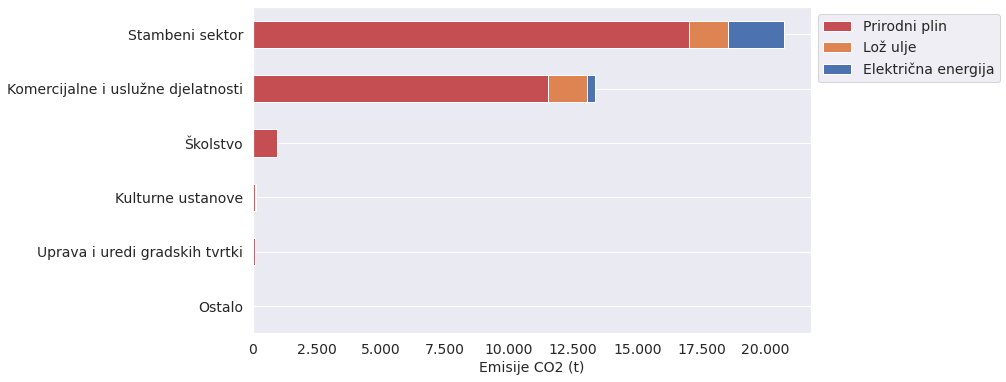

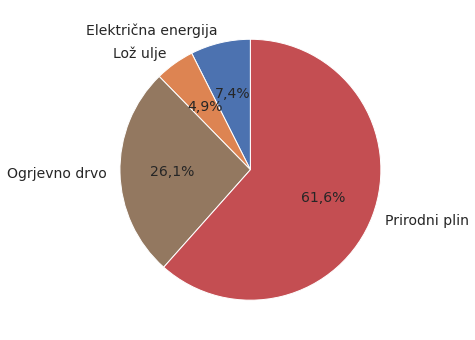

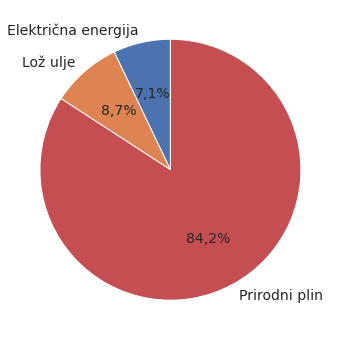

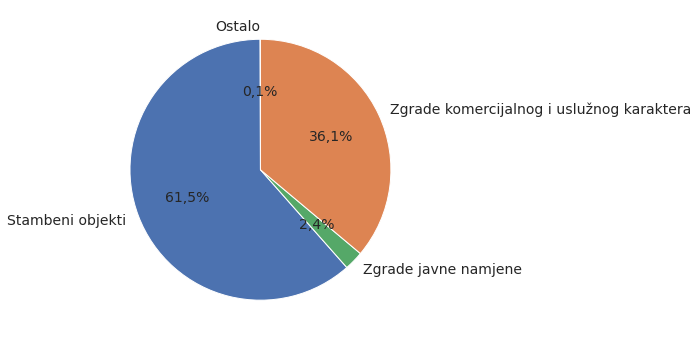

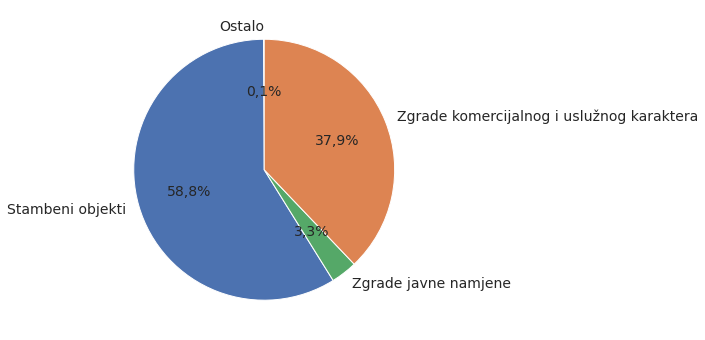

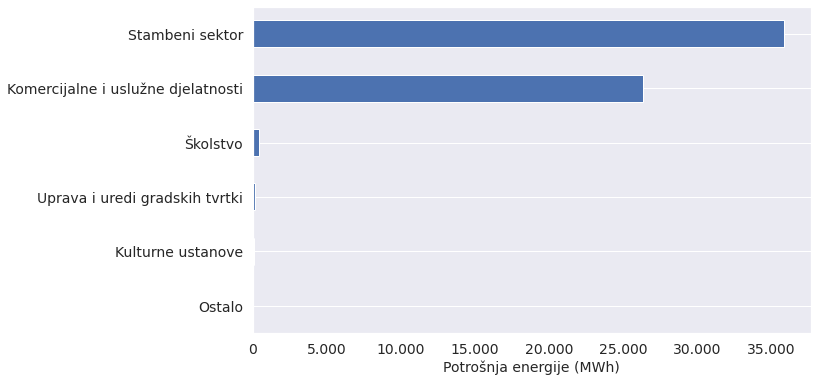

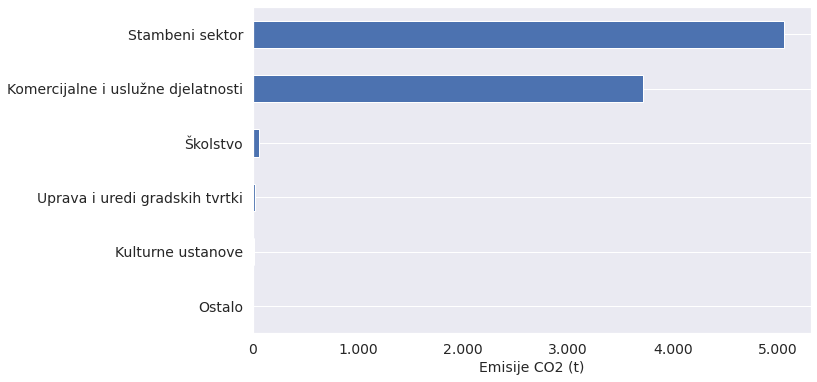

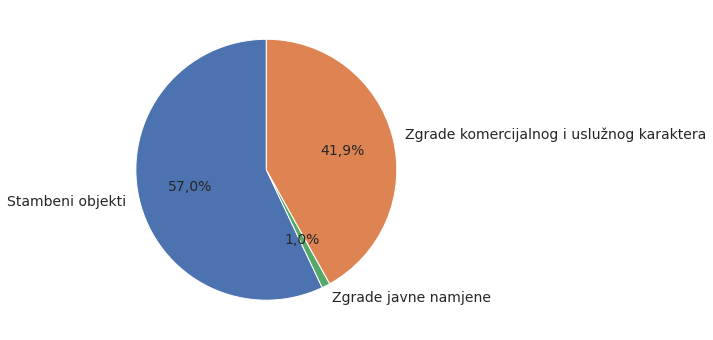

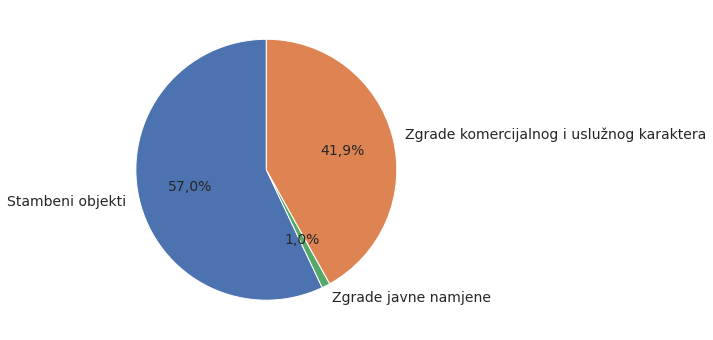

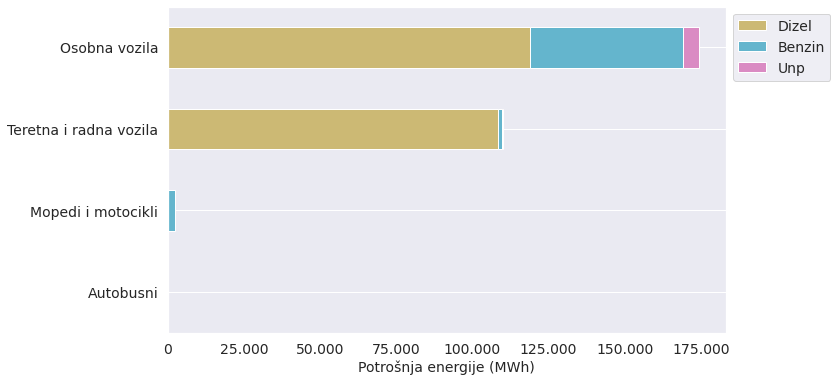

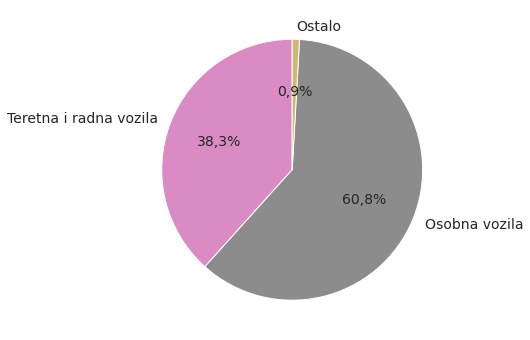

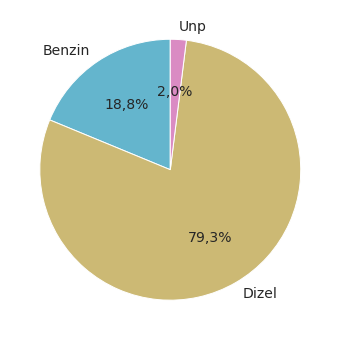

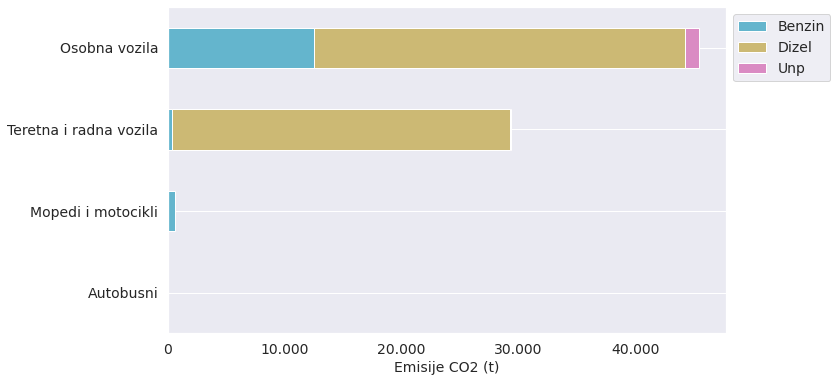

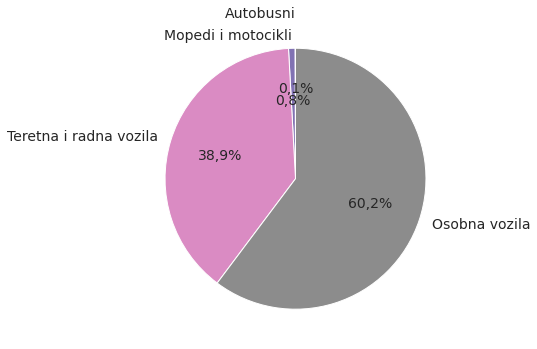

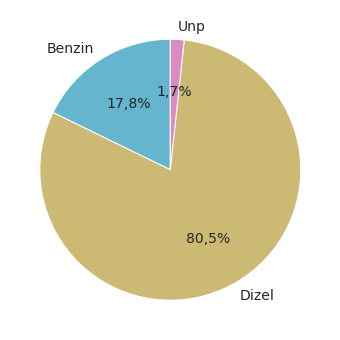

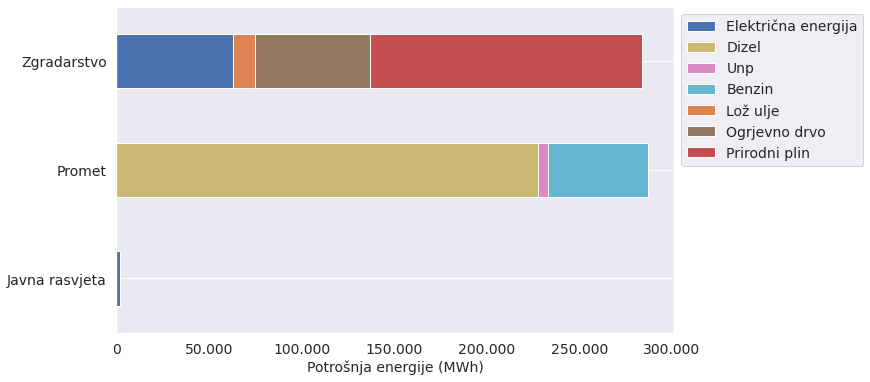

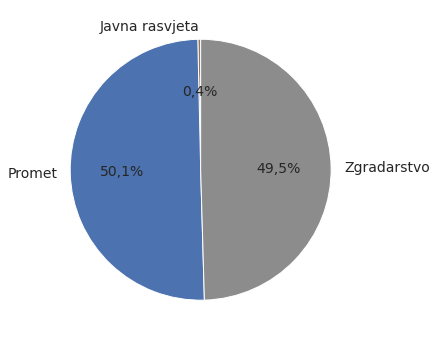

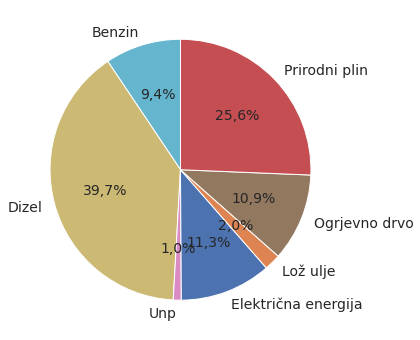

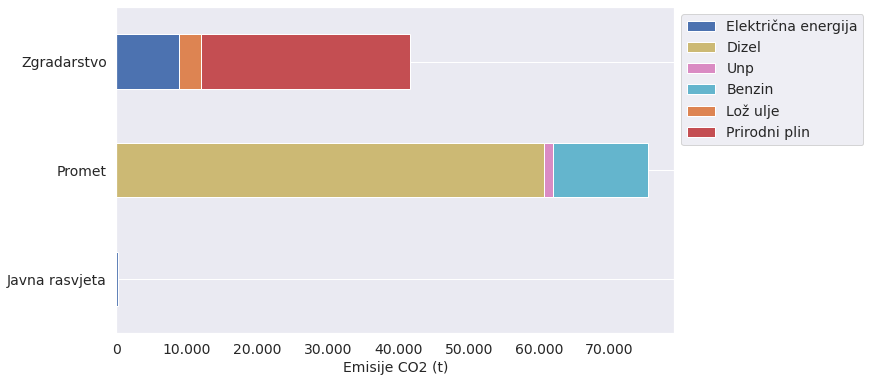

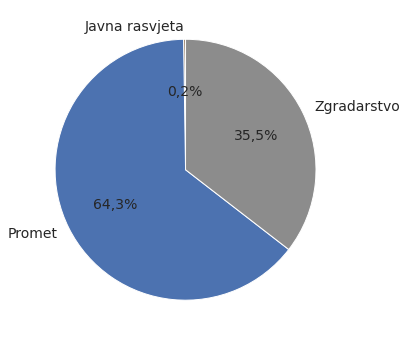

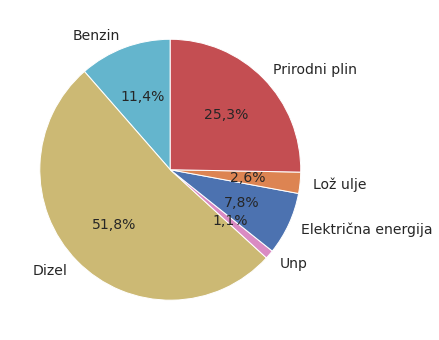

In [37]:
# 2019
output_dir = root_dir / 'output/2019/'
heat_2019 = pd.read_csv(root_dir / 'data/2019/vinkovci_grijanje_2019.csv')
ele_2019 = pd.read_csv(root_dir / 'data/2019/vinkovci_struja_2019.csv')
trans_2019 = pd.read_csv(root_dir / 'data/2019/privatna_vozila_2019.csv')
light_2019_mwh = 2008.656
light_2019_co2 = light_2019_mwh * constants.co2_electricity_mwh_ton_2019
light_2019 = ['električna energija', light_2019_mwh, light_2019_co2, 'javna rasvjeta']

base_inventory_2019 = Inventory(constants, 2019)
inventory_2019 = base_inventory_2019.base_inventory(output_dir, heat_2019, ele_2019, trans_2019, light_2019)

In [38]:
inventory_2019.keys()

dict_keys(['heat', 'heat_co2', 'electricity', 'electricity_co2', 'transport', 'transport_co2', 'total', 'total_co2'])

## Potrošnja energije

In [39]:
inventory_2019['heat']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
ostalo,147.1,0.0,0.0,0.0
uprava i uredi gradskih tvrtki,445.2,0.0,0.0,0.0
kulturne ustanove,498.6,40.6,0.0,0.0
školstvo,4689.6,0.0,0.0,0.0
komercijalne i uslužne djelatnosti,56945.1,5884.9,21196.1,2136.8
stambeni sektor,84202.2,5746.4,41111.3,15599.6


In [40]:
inventory_2019['heat'].sum()

energent
prirodni plin         146927.7
lož ulje               11671.9
ogrjevno drvo          62307.4
električna energija    17736.4
dtype: float64

In [41]:
inventory_2019['heat'].sum(axis=1)

kategorija
ostalo                                  147.1
uprava i uredi gradskih tvrtki          445.2
kulturne ustanove                       539.1
školstvo                               4689.6
komercijalne i uslužne djelatnosti    86162.9
stambeni sektor                      146659.5
dtype: float64

In [42]:
inventory_2019['heat'].sum().sum()

238643.44744066068

## Potrošnja CO2

In [43]:
inventory_2019['heat_co2']

energent,prirodni plin,lož ulje,ogrjevno drvo,električna energija
kategorija,,,,
ostalo,29.7,0.0,0.0,0.0
uprava i uredi gradskih tvrtki,89.9,0.0,0.0,0.0
kulturne ustanove,100.7,10.7,0.0,0.0
školstvo,947.3,0.0,0.0,0.0
komercijalne i uslužne djelatnosti,11502.9,1553.6,0.0,301.3
stambeni sektor,17008.8,1517.1,0.0,2199.6


In [44]:
inventory_2019['heat_co2'].sum()

energent
prirodni plin         29679.4
lož ulje               3081.4
ogrjevno drvo             0.0
električna energija    2500.9
dtype: float64

In [45]:
inventory_2019['heat_co2'].sum(axis=1)

kategorija
ostalo                                  29.7
uprava i uredi gradskih tvrtki          89.9
kulturne ustanove                      111.4
školstvo                               947.3
komercijalne i uslužne djelatnosti   13357.8
stambeni sektor                      20725.5
dtype: float64

In [46]:
inventory_2019['heat_co2'].sum().sum()

35261.66047253434

## Struja

In [47]:
inventory_2019['electricity']

kategorija
ostalo                                  27.0
kulturne ustanove                       80.1
uprava i uredi gradskih tvrtki         160.0
školstvo                               403.6
komercijalne i uslužne djelatnosti   26362.5
stambeni sektor                      35864.4
Name: potrošnja_energije(MWh), dtype: float64

In [48]:
inventory_2019['electricity'].sum()

62897.483

## Struja CO2

In [49]:
inventory_2019['electricity_co2']

kategorija
ostalo                                  3.8
kulturne ustanove                      11.3
uprava i uredi gradskih tvrtki         22.6
školstvo                               56.9
komercijalne i uslužne djelatnosti   3717.2
stambeni sektor                      5057.0
Name: Emisije CO2 (t), dtype: float64

In [50]:
inventory_2019['electricity_co2'].sum()

8868.694316351699

## Transport

In [51]:
trans_2019

,vrsta_prijevoza,broj,benzin,benzin-lpg,dizel,električni,hibridni,hibridni s vanjskim punjenjem,prosjek_km_po_vozilu,procijenjena_potrošena_masa_benzina(t),procijenjena_potrošena_masa_dizela(t),procijenjena_potrošena_masa_unp(t)
0,mopedi i motocikli,1091,1089.0,nan,nan,2.0,nan,nan,3000.0,195.8,0.0,0.0
1,osobna vozila,18859,6935.0,910.0,10986.0,1.0,27.0,2.0,12856.3,4077.2,9991.4,409.6
2,teretna i radna vozila,5072,47.0,15.0,5009.0,1.0,nan,nan,31000.0,106.3,9111.1,22.7
3,autobusni,4,nan,nan,4.0,nan,nan,nan,61408.0,0.0,14.4,0.0


In [52]:
trans_2019.sum()

vrsta_prijevoza                           mopedi i motocikliosobna vozilateretna i radna...
broj                                                                                  25026
benzin                                                                               8071.0
benzin-lpg                                                                            925.0
dizel                                                                               15999.0
električni                                                                              4.0
hibridni                                                                               27.0
hibridni s vanjskim punjenjem                                                           2.0
prosjek_km_po_vozilu                                                               108264.3
procijenjena_potrošena_masa_benzina(t)                                               4379.3
procijenjena_potrošena_masa_dizela(t)                                           

In [53]:
inventory_2019['transport'].sum(axis=1).sum()

287020.37631856505

In [54]:
inventory_2019['transport'].sum(axis=1).sum()

287020.37631856505

## Transport CO2

In [55]:
inventory_2019['transport_co2']

energent,Benzin,Dizel,UNP
vrsta_prijevoza,,,
autobusni,0.0,45.8,0.0
mopedi i motocikli,599.5,0.0,0.0
teretna i radna vozila,325.7,28948.6,67.6
osobna vozila,12487.3,31745.8,1217.9


In [56]:
inventory_2019['transport_co2'].sum()

energent
Benzin   13412.5
Dizel    60740.2
UNP       1285.6
dtype: float64

In [57]:
inventory_2019['transport_co2'].sum(axis=1)

vrsta_prijevoza
autobusni                   45.8
mopedi i motocikli         599.5
teretna i radna vozila   29342.0
osobna vozila            45451.0
dtype: float64

In [58]:
inventory_2019['transport_co2'].sum(axis=1).sum()

75438.32390382494

## UKupna potrošnja

In [59]:
inventory_2019['total'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,2008.7,0.0,62897.5
Dizel,0.0,227491.4,0.0
UNP,0.0,5663.4,0.0
Benzin,0.0,53865.5,0.0
lož ulje,0.0,0.0,11671.9
ogrjevno drvo,0.0,0.0,62307.4
prirodni plin,0.0,0.0,146927.7


In [60]:
inventory_2019['total'].T.sum(axis=1)

energent
električna energija    64906.1
Dizel                 227491.4
UNP                     5663.4
Benzin                 53865.5
lož ulje               11671.9
ogrjevno drvo          62307.4
prirodni plin         146927.7
dtype: float64

In [61]:
inventory_2019['total'].T.sum()

sektor
javna rasvjeta     2008.7
promet           287020.4
zgradarstvo      283804.5
dtype: float64

In [62]:
inventory_2019['total'].T.sum().sum()

572833.5613164824

## Ukupna potrošnja CO2

In [63]:
inventory_2019['total_co2'].T

sektor,javna rasvjeta,promet,zgradarstvo
energent,,,
električna energija,283.2,0.0,8868.7
Dizel,0.0,60740.2,0.0
UNP,0.0,1285.6,0.0
Benzin,0.0,13412.5,0.0
lož ulje,0.0,0.0,3081.4
prirodni plin,0.0,0.0,29679.4


In [64]:
inventory_2019['total_co2'].T.sum()

sektor
javna rasvjeta     283.2
promet           75438.3
zgradarstvo      41629.5
dtype: float64

In [65]:
inventory_2019['total_co2'].T.sum(axis=1)

energent
električna energija    9151.9
Dizel                 60740.2
UNP                    1285.6
Benzin                13412.5
lož ulje               3081.4
prirodni plin         29679.4
dtype: float64

In [66]:
inventory_2019['total_co2'].T.sum().sum()

117351.02927394038

# Usporedba

In [67]:
co2_keys = [key for key in inventory_2019.keys() if key.endswith('co2')]
mwh_keys = [key for key in inventory_2019.keys() if not key.endswith('co2')]

In [68]:
for i in inventory_2019.keys():
    try:
        inventory_2019[i].drop('ostalo', inplace=True)
    except:
        'Ostalo not found in axis'

Input is a series
Input is a series


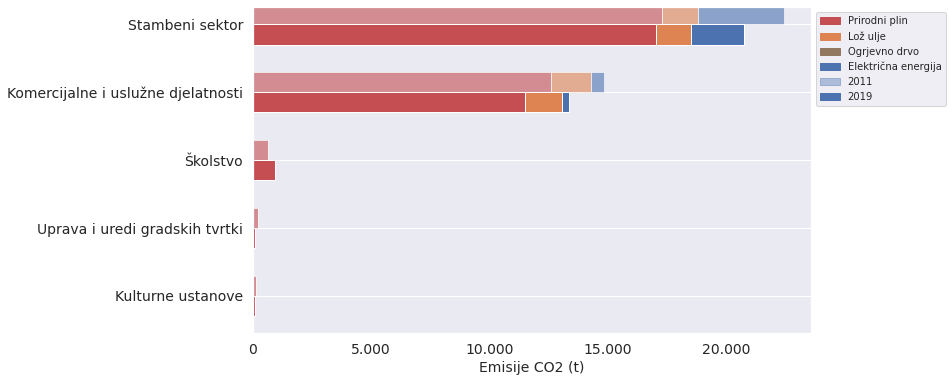

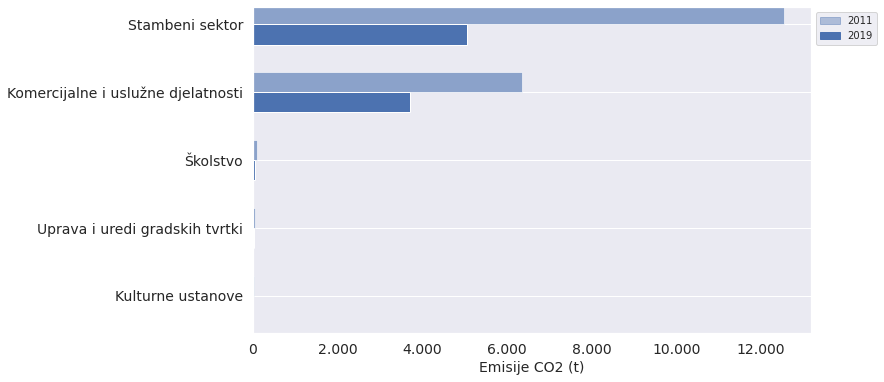

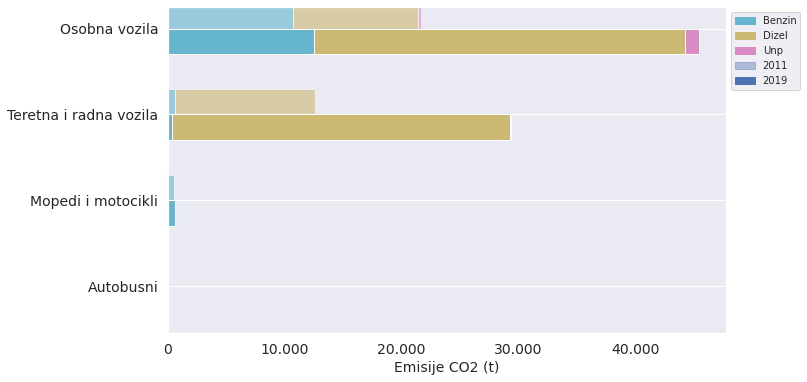

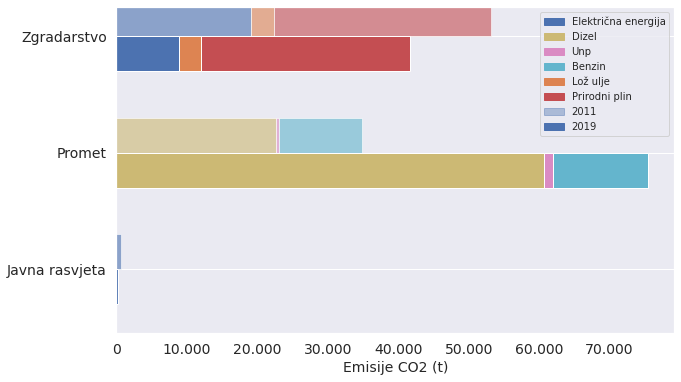

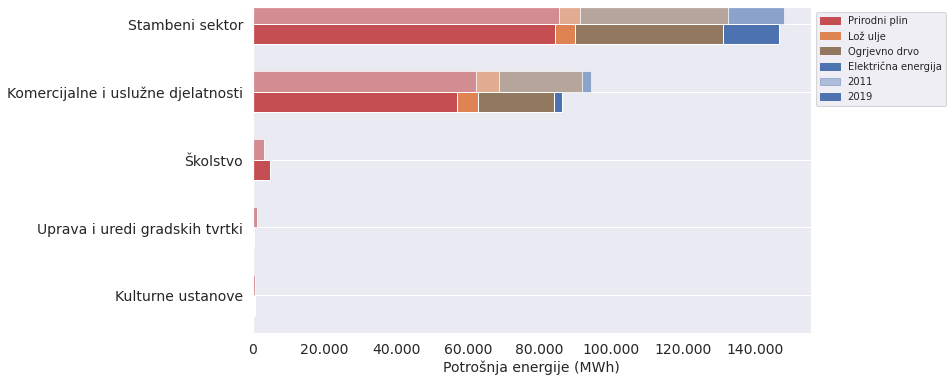

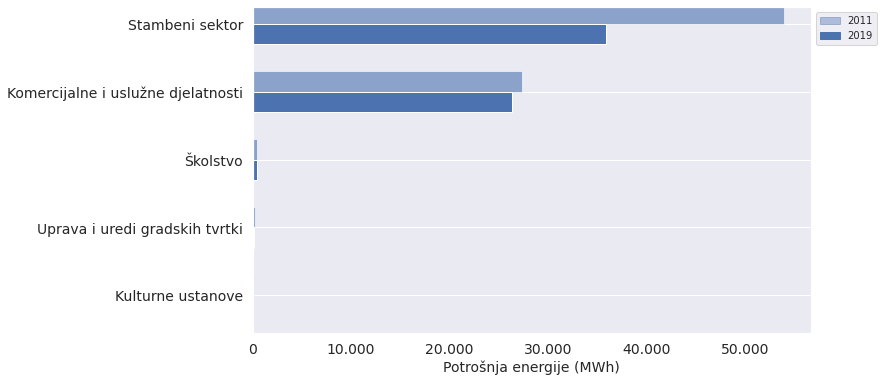

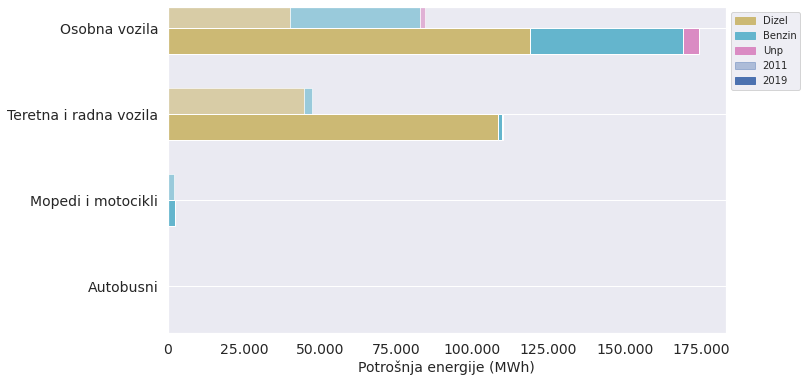

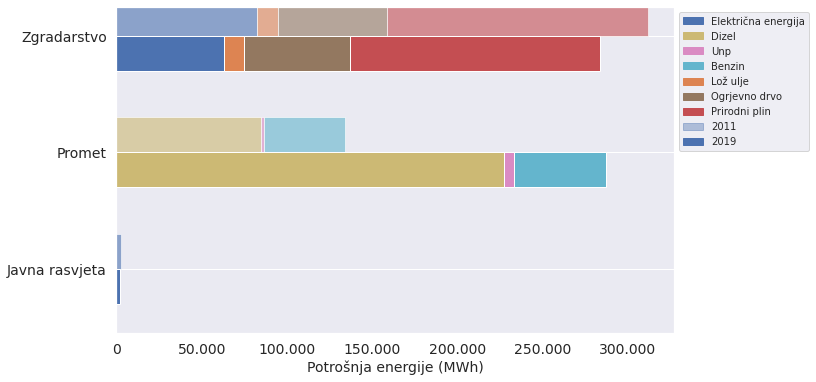

In [69]:
output_dir = root_dir / 'output/2011v2019/'

for key in co2_keys:
    comparison_fig = base_inventory_2019.compare_stacked_bar(
        inventory_2011[key],
        inventory_2019[key],
        '2011',
        '2019',
        title='Emisije CO2 (t)',
    )
    comparison_fig.savefig(output_dir / '{}_comparison.png'.format(key), dpi=300, bbox_inches='tight')
    
for key in mwh_keys:
    comparison_fig = base_inventory_2019.compare_stacked_bar(
        inventory_2011[key],
        inventory_2019[key],
        '2011',
        '2019',
        title='Potrošnja energije (MWh)',
    )
    comparison_fig.savefig(output_dir / '{}_comparison.png'.format(key), dpi=300, bbox_inches='tight')

In [70]:
def percent_difference(df1, df2):
    percent_diff = ((df2 - df1) / df1) * 100
    return percent_diff

## Razlika u potrošnji energije u zgradarstvu

In [71]:
mwh_keys

['heat', 'electricity', 'transport', 'total']

In [72]:
inventory_2011['heat'].sum(axis=1)

kategorija
kulturne ustanove                       720.9
uprava i uredi gradskih tvrtki         1104.7
školstvo                               3234.7
komercijalne i uslužne djelatnosti    94277.9
stambeni sektor                      148220.0
dtype: float64

In [73]:
inventory_2019['heat'].sum(axis=1)

kategorija
uprava i uredi gradskih tvrtki          445.2
kulturne ustanove                       539.1
školstvo                               4689.6
komercijalne i uslužne djelatnosti    86162.9
stambeni sektor                      146659.5
dtype: float64

In [74]:
inventory_2011['heat'].sum(axis=1).sum()

247558.33119

In [75]:
inventory_2019['heat'].sum(axis=1).sum()

238496.36344066064

In [76]:
percent_difference(
    inventory_2011['heat'].sum(axis=1),
    inventory_2019['heat'].sum(axis=1)
)

kategorija
komercijalne i uslužne djelatnosti    -8.6
kulturne ustanove                    -25.2
stambeni sektor                       -1.1
uprava i uredi gradskih tvrtki       -59.7
školstvo                              45.0
dtype: float64

In [77]:
percent_difference(
    inventory_2011['heat'].sum(axis=1).sum(),
    inventory_2019['heat'].sum(axis=1).sum()
)

-3.660538389388451

## Emisije CO2 u zgradarstvu

In [78]:
inventory_2011['heat_co2'].sum(axis=1)

kategorija
kulturne ustanove                      149.6
uprava i uredi gradskih tvrtki         224.3
školstvo                               654.4
komercijalne i uslužne djelatnosti   14830.4
stambeni sektor                      22439.3
dtype: float64

In [79]:
inventory_2019['heat_co2'].sum(axis=1)

kategorija
uprava i uredi gradskih tvrtki          89.9
kulturne ustanove                      111.4
školstvo                               947.3
komercijalne i uslužne djelatnosti   13357.8
stambeni sektor                      20725.5
dtype: float64

In [80]:
inventory_2011['heat_co2'].sum(axis=1).sum()

38297.86441327803

In [81]:
inventory_2019['heat_co2'].sum(axis=1).sum()

35231.94950453434

In [82]:
percent_difference(
    inventory_2011['heat_co2'].sum(axis=1),
    inventory_2019['heat_co2'].sum(axis=1)
)

kategorija
komercijalne i uslužne djelatnosti    -9.9
kulturne ustanove                    -25.5
stambeni sektor                       -7.6
uprava i uredi gradskih tvrtki       -59.9
školstvo                              44.8
dtype: float64

In [83]:
percent_difference(
    inventory_2011['heat'].sum(axis=1).sum(),
    inventory_2019['heat'].sum(axis=1).sum()
)

-3.660538389388451

## Potrošnja električne u zgradarstvu

In [84]:
inventory_2011['electricity']

kategorija
kulturne ustanove                      125.7
uprava i uredi gradskih tvrtki         220.3
školstvo                               455.9
komercijalne i uslužne djelatnosti   27390.0
stambeni sektor                      54014.0
Name: potrošnja_energije(MWh), dtype: float64

In [85]:
inventory_2019['electricity']

kategorija
kulturne ustanove                       80.1
uprava i uredi gradskih tvrtki         160.0
školstvo                               403.6
komercijalne i uslužne djelatnosti   26362.5
stambeni sektor                      35864.4
Name: potrošnja_energije(MWh), dtype: float64

In [86]:
inventory_2011['electricity'].sum()

82205.917

In [87]:
inventory_2019['electricity'].sum()

62870.475999999995

In [88]:
percent_difference(
    inventory_2011['electricity'],
    inventory_2019['electricity']
)

kategorija
kulturne ustanove                    -36.3
uprava i uredi gradskih tvrtki       -27.4
školstvo                             -11.5
komercijalne i uslužne djelatnosti    -3.8
stambeni sektor                      -33.6
Name: potrošnja_energije(MWh), dtype: float64

In [89]:
percent_difference(
    inventory_2011['electricity'].sum(),
    inventory_2019['electricity'].sum()
)

-23.52074121379852

## Emisije CO2 električne energije u zgradarstvu

In [90]:
inventory_2011['electricity_co2']

kategorija
kulturne ustanove                       29.2
uprava i uredi gradskih tvrtki          51.2
školstvo                               105.9
komercijalne i uslužne djelatnosti    6363.2
stambeni sektor                      12548.5
Name: Emisije CO2 (t), dtype: float64

In [91]:
inventory_2019['electricity_co2']

kategorija
kulturne ustanove                      11.3
uprava i uredi gradskih tvrtki         22.6
školstvo                               56.9
komercijalne i uslužne djelatnosti   3717.2
stambeni sektor                      5057.0
Name: Emisije CO2 (t), dtype: float64

In [92]:
inventory_2011['electricity_co2'].sum()

19098.05893842394

In [93]:
inventory_2019['electricity_co2'].sum()

8864.886265282283

In [94]:
percent_difference(
    inventory_2011['electricity_co2'],
    inventory_2019['electricity_co2']
)

kategorija
kulturne ustanove                    -61.3
uprava i uredi gradskih tvrtki       -55.9
školstvo                             -46.3
komercijalne i uslužne djelatnosti   -41.6
stambeni sektor                      -59.7
Name: Emisije CO2 (t), dtype: float64

In [95]:
percent_difference(
    inventory_2011['electricity_co2'].sum(),
    inventory_2019['electricity_co2'].sum()
)

-53.58226564351647

## Razlika potrošnje u transportu

In [96]:
inventory_2011['transport'].sum()

Dizel    84988.6
Benzin   47576.3
UNP       1381.3
dtype: float64

In [97]:
inventory_2011['transport'].sum().sum()

133946.12157006646

In [98]:
inventory_2019['transport'].sum()

Dizel    227491.4
Benzin    53865.5
UNP        5663.4
dtype: float64

In [99]:
inventory_2019['transport'].sum().sum()

287020.376318565

In [100]:
percent_difference(
    inventory_2011['transport'].sum(),
    inventory_2019['transport'].sum()
)

Dizel    167.7
Benzin    13.2
UNP      310.0
dtype: float64

In [101]:
percent_difference(
    inventory_2011['transport'].sum().sum(),
    inventory_2019['transport'].sum().sum()
)

114.28046811226724

## Razlika co2 u transportu

In [102]:
inventory_2011['transport_co2'].sum()

energent
Benzin   11846.5
Dizel    22691.9
UNP        313.5
dtype: float64

In [103]:
inventory_2011['transport_co2'].sum().sum()

34851.9910813887

In [104]:
inventory_2019['transport_co2'].sum()

energent
Benzin   13412.5
Dizel    60740.2
UNP       1285.6
dtype: float64

In [105]:
inventory_2019['transport_co2'].sum().sum()

75438.32390382494

In [106]:
percent_difference(
    inventory_2011['transport_co2'].sum(),
    inventory_2019['transport_co2'].sum()
)

energent
Benzin    13.2
Dizel    167.7
UNP      310.0
dtype: float64

In [107]:
percent_difference(
    inventory_2011['transport_co2'].sum().sum(),
    inventory_2019['transport_co2'].sum().sum()
)

116.45341216705903

## Ukupna razlika energent

In [108]:
inventory_2011['total'].sum()

energent
električna energija    85128.4
Dizel                  84988.6
UNP                     1381.3
Benzin                 47576.3
lož ulje               12279.8
ogrjevno drvo          64439.4
prirodni plin         152814.7
dtype: float64

In [109]:
inventory_2011['total'].sum().sum()

448608.5017600664

In [110]:
inventory_2019['total'].sum()

energent
električna energija    64906.1
Dizel                 227491.4
UNP                     5663.4
Benzin                 53865.5
lož ulje               11671.9
ogrjevno drvo          62307.4
prirodni plin         146927.7
dtype: float64

In [111]:
inventory_2019['total'].sum().sum()

572833.5613164824

In [112]:
percent_difference(
    inventory_2011['total'].sum(),
    inventory_2019['total'].sum()
)

energent
električna energija   -23.8
Dizel                 167.7
UNP                   310.0
Benzin                 13.2
lož ulje               -5.0
ogrjevno drvo          -3.3
prirodni plin          -3.9
dtype: float64

In [113]:
percent_difference(
    inventory_2011['total'].sum().sum(),
    inventory_2019['total'].sum().sum()
)

27.691196013680635

## Ukupna razlika CO2 energent

In [114]:
inventory_2011['total_co2'].sum()

energent
električna energija   19776.1
Dizel                 22691.9
UNP                     313.5
Benzin                11846.5
lož ulje               3241.9
prirodni plin         30868.6
dtype: float64

In [115]:
inventory_2011['total_co2'].sum().sum()

88738.49757851264

In [116]:
inventory_2019['total_co2'].sum()

energent
električna energija    9151.9
Dizel                 60740.2
UNP                    1285.6
Benzin                13412.5
lož ulje               3081.4
prirodni plin         29679.4
dtype: float64

In [117]:
inventory_2019['total_co2'].sum().sum()

117351.02927394037

In [118]:
percent_difference(
    inventory_2011['total_co2'].sum(),
    inventory_2019['total_co2'].sum()
)

energent
električna energija   -53.7
Dizel                 167.7
UNP                   310.0
Benzin                 13.2
lož ulje               -5.0
prirodni plin          -3.9
dtype: float64

In [119]:
percent_difference(
    inventory_2011['total_co2'].sum().sum(),
    inventory_2019['total_co2'].sum().sum()
)

32.24365126321006

## Ukupna potrošnja sektor

In [120]:
inventory_2011['total'].sum(axis=1)

sektor
javna rasvjeta     2922.5
promet           133946.1
zgradarstvo      311739.9
dtype: float64

In [121]:
inventory_2011['total'].sum(axis=1).sum()

448608.5017600665

In [122]:
inventory_2019['total'].sum(axis=1)

sektor
javna rasvjeta     2008.7
promet           287020.4
zgradarstvo      283804.5
dtype: float64

In [123]:
inventory_2019['total'].sum(axis=1).sum()

572833.5613164824

In [124]:
percent_difference(
    inventory_2011['total'].sum(axis=1),
    inventory_2019['total'].sum(axis=1)
)

sektor
javna rasvjeta   -31.3
promet           114.3
zgradarstvo       -9.0
dtype: float64

In [125]:
percent_difference(
    inventory_2011['total'].sum(axis=1).sum(),
    inventory_2019['total'].sum(axis=1).sum()
)

27.691196013680617

## Ukupne emisije CO2 sektor

In [126]:
inventory_2011['total_co2'].sum(axis=1)

sektor
javna rasvjeta     678.0
promet           34852.0
zgradarstvo      53208.5
dtype: float64

In [127]:
inventory_2011['total_co2'].sum(axis=1).sum()

88738.49757851264

In [128]:
inventory_2019['total_co2'].sum(axis=1)

sektor
javna rasvjeta     283.2
promet           75438.3
zgradarstvo      41629.5
dtype: float64

In [129]:
inventory_2019['total_co2'].sum(axis=1).sum()

117351.02927394038

In [130]:
percent_difference(
    inventory_2011['total_co2'].sum(axis=1),
    inventory_2019['total_co2'].sum(axis=1)
)

sektor
javna rasvjeta   -58.2
promet           116.5
zgradarstvo      -21.8
dtype: float64

In [131]:
percent_difference(
    inventory_2011['total_co2'].sum(axis=1).sum(),
    inventory_2019['total_co2'].sum(axis=1).sum()
)

32.243651263210076

## Vrsta vozila

In [132]:
cars_2011 = [6, 10005, 2102, 910]
cars_2019 = [4, 18859, 5072, 1091]
cols = ['Autobusni', 'Osobna vozila', 'Teretna i radna vozila', 'Mopedi i motocikli']

In [133]:
cars_2011 = pd.Series(cars_2011, cols)
cars_2019 = pd.Series(cars_2019, cols)

In [134]:
percent_difference(
    cars_2011,
    cars_2019
)

Autobusni                -33.3
Osobna vozila             88.5
Teretna i radna vozila   141.3
Mopedi i motocikli        19.9
dtype: float64

In [135]:
percent_difference(
    cars_2011.sum(),
    cars_2019.sum()
)

92.16770329417186

# Mjere ublazavanja

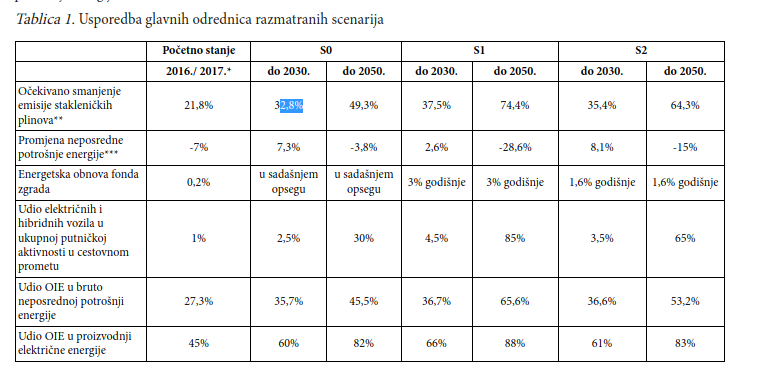!

## Promjene u emisijskom faktoru elektricne energije

* predviđeni emisijski faktor je 0.092 prema strategiji prilagodbe

In [136]:
ele_2030_index = 0.092

## Promjene u učinkovitosti motora

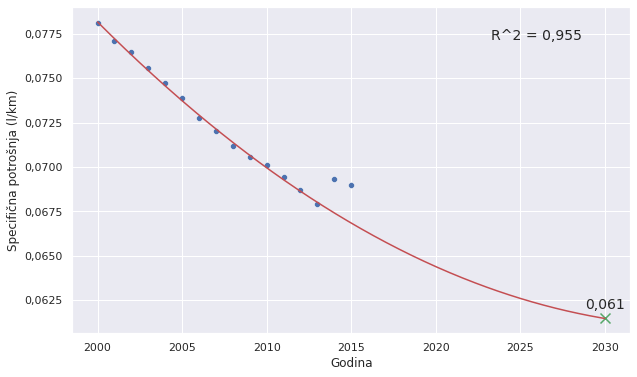

In [137]:
engine_efficiency_2030, figure = engine_efficiency_projection()

## Godišnja promjena energije - Business as usual

In [138]:
change_per_year = percent_difference(
    inventory_2011['total'].sum(axis=1),
    inventory_2019['total'].sum(axis=1)
) / 8

change_until_2023 = change_per_year * 11 / 100
change_inventory_2023 = inventory_2019['total'].sum(axis=1) * change_until_2023
inventory_2030 = inventory_2019['total'].sum(axis=1) + change_inventory_2023

# use 0.025 share of electric cars from Offical strategy (NN 25/2020)
n_electric_cars_2030 = int(trans_2019.sum()['broj'] - (trans_2019.sum()['broj'] * 0.025))

# gains in projected engine efficiency
engine_efficiency_factor = engine_efficiency_2030 / constants.specific_consumption_total_2005

# approximate as energy consumption per car
energy_per_car = inventory_2019['total'].sum(axis=1)['promet'] / trans_2019.sum()['broj']
energy_trans_2030 = energy_per_car * n_electric_cars_2030 * engine_efficiency_factor
inventory_2030['promet'] = energy_trans_2030

inventory_2030

sektor
javna rasvjeta     1145.0
promet           232896.6
zgradarstvo      248835.5
dtype: float64

## Promjena u potrošnji CO2 - Business as usual

In [139]:
co2_per_car_2019 = inventory_2019['total_co2'].sum(axis=1)['promet'] / int(trans_2019.sum()['broj'])
co2_transport_2030 = co2_per_car_2019 * n_electric_cars_2030

# co2 change to 2030
electricity_co2_2019 = inventory_2019['total_co2']['električna energija'].sum()
dif_ele_emission_factor = ele_2030_index / constants.co2_electricity_mwh_ton_2019
electricity_co2_2030_saved_light = (1-dif_ele_emission_factor) * inventory_2019['total_co2'].loc['javna rasvjeta']['električna energija']
electricity_co2_2030_saved_buildings = (1-dif_ele_emission_factor) * inventory_2019['total_co2'].loc['zgradarstvo']['električna energija']

inventory_2030_co2 = inventory_2019['total_co2'].copy()
inventory_2030_co2

energent,električna energija,Dizel,UNP,Benzin,lož ulje,prirodni plin
sektor,,,,,,
javna rasvjeta,283.2,0.0,0.0,0.0,0.0,0.0
promet,0.0,60740.2,1285.6,13412.5,0.0,0.0
zgradarstvo,8868.7,0.0,0.0,0.0,3081.4,29679.4


In [140]:
inventory_2030_co2.loc['javna rasvjeta']['električna energija'] = inventory_2030_co2.loc['javna rasvjeta']['električna energija'] - electricity_co2_2030_saved_light 
inventory_2030_co2.loc['zgradarstvo']['električna energija'] = inventory_2030_co2.loc['zgradarstvo']['električna energija'] - electricity_co2_2030_saved_buildings

co2_2030_sector_scaling = inventory_2030_co2.sum(axis=1) / inventory_2019['total'].sum(axis=1)
inventory_2030_co2 = inventory_2030 * co2_2030_sector_scaling

inventory_2030_co2

sektor
javna rasvjeta     105.3
promet           61212.8
zgradarstvo      33797.7
dtype: float64

* Graf potrošnje energije

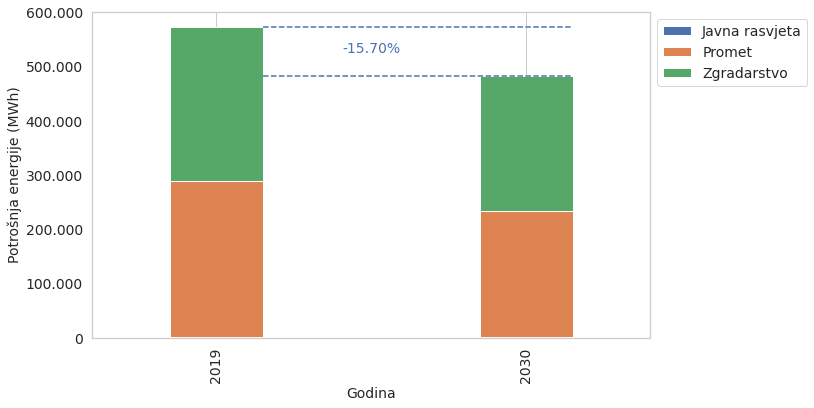

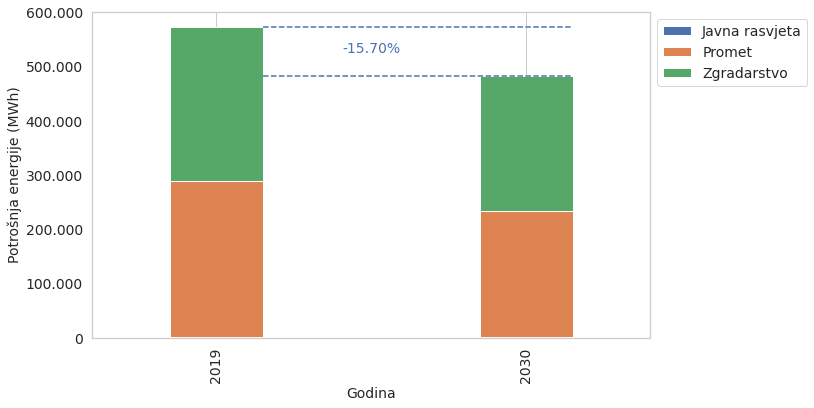

In [141]:
inventory_2030 = inventory_2030.reset_index()
inventory_2019_total = inventory_2019['total'].sum(axis=1).reset_index()
inventory_2019_total['Godina'] = 2019
inventory_2030['Godina'] = 2030
projection_total = pd.concat([inventory_2019_total, inventory_2030])
base_inventory_2019.projection_bar(projection_total, 'Potrošnja energije (MWh)')

* graf potrošnje CO2

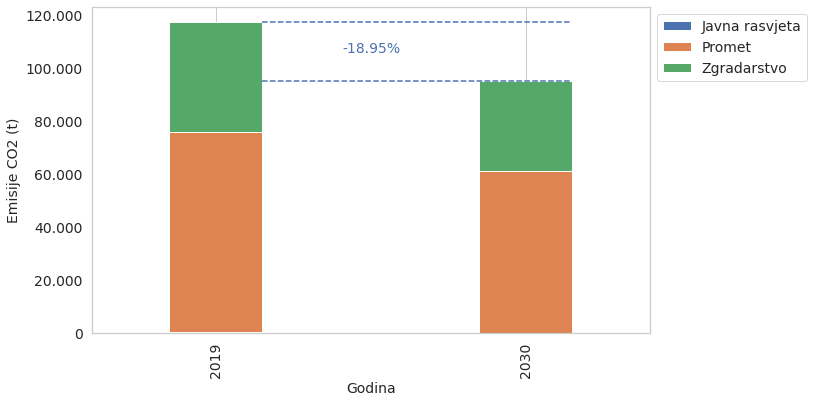

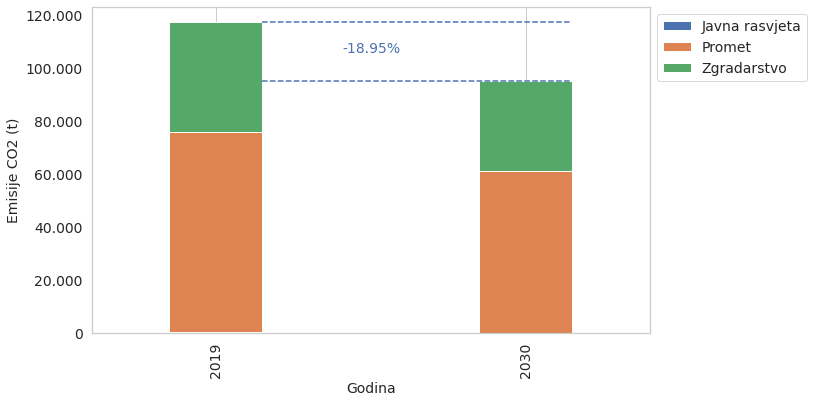

In [142]:
inventory_2030_co2 = inventory_2030_co2.reset_index()
inventory_2019_total_co2 = inventory_2019['total_co2'].sum(axis=1).reset_index()
inventory_2019_total_co2['Godina'] = 2019
inventory_2030_co2['Godina'] = 2030
projection_total = pd.concat([inventory_2019_total_co2, inventory_2030_co2])
base_inventory_2019.projection_bar(projection_total, 'Emisije CO2 (t)')

## Promjena potrošnje energije - Ubrzana energetska tranzicija

* Ušteda energije i CO2 od Poticanja eko-vožnje 7,5% od ukupnog prometa (struktura vozila iz 2019)
* Ušteda energije i CO2 5% od poticanja korištenja bicikala, e-bicikala i unapređivanja biciklističkog prometa

In [143]:
eco_driving = inventory_2019['total'].sum(axis=1)['promet'] * 0.1
bike_mobility = inventory_2019['total'].sum(axis=1)['promet'] * 0.1
electromobility = inventory_2019['total'].sum(axis=1)['promet'] * 0.075
city_vehicles_savings = 23.47

In [144]:
energy_per_car_s2 = inventory_2019['total'].sum(axis=1)['promet'] / trans_2019.sum()['broj']

In [145]:
eco_driving_co2 = eco_driving * co2_2030_sector_scaling['promet']
bike_mobility_co2 = bike_mobility * co2_2030_sector_scaling['promet']
electromobility_co2 = electromobility * co2_2030_sector_scaling['promet']
cars_2030_s2_co2 = (trans_2019.sum()['broj'] * 0.15) * energy_per_car_s2 * co2_2030_sector_scaling['promet']

* Ušteda energije od električnih auta

In [146]:
n_electric_cars_2030_s2 = int(trans_2019.sum()['broj'] - (trans_2019.sum()['broj'] * 0.15))
energy_trans_2030_s2 = (energy_per_car_s2 * n_electric_cars_2030_s2 * engine_efficiency_factor) - electromobility - city_vehicles_savings - eco_driving - bike_mobility
inventory_2030_s2 = inventory_2030.copy()
promet_loc = inventory_2030_s2['sektor'] == 'promet'
inventory_2030_s2.loc[promet_loc, 0] = energy_trans_2030_s2

zgradarstvo_loc = inventory_2030_s2['sektor'] == 'zgradarstvo'
inventory_2030_s2.loc[zgradarstvo_loc, 0] = inventory_2030_s2.loc[zgradarstvo_loc][0] - 107595.73

rasvjeta_loc = inventory_2030_s2['sektor'] == 'javna rasvjeta'
inventory_2030_s2.loc[rasvjeta_loc, 0] = inventory_2030_s2.loc[rasvjeta_loc][0] - 365.568

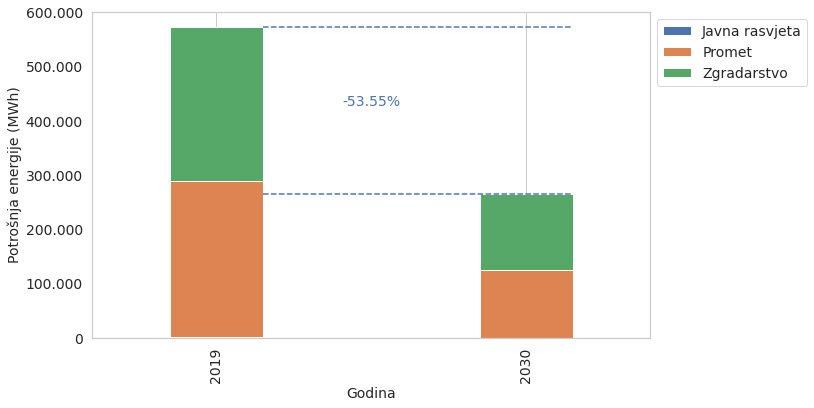

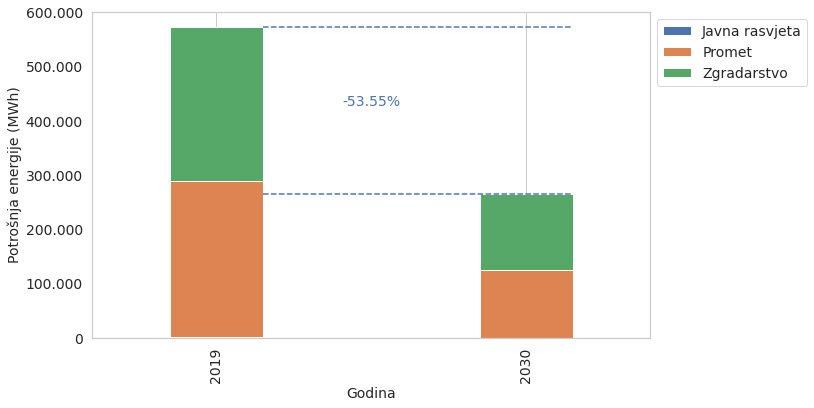

In [147]:
projection_total = pd.concat([inventory_2019_total, inventory_2030_s2])
base_inventory_2019.projection_bar(projection_total, 'Potrošnja energije (MWh)')

## Promjena emisija CO2 - Ubrzana energetska tranzicija

In [148]:
inventory_2030_co2_s2 = inventory_2030_co2.copy()

In [149]:
inventory_2030_co2_s2.loc[inventory_2030_co2_s2['sektor'] == 'promet', 0] = inventory_2030_co2_s2.loc[inventory_2030_co2_s2['sektor'] == 'promet'][0] - 18865.09 
inventory_2030_co2_s2.loc[inventory_2030_co2_s2['sektor'] == 'zgradarstvo', 0][0] = inventory_2030_co2_s2.loc[inventory_2030_co2_s2['sektor'] == 'zgradarstvo'][0] - 22293,78

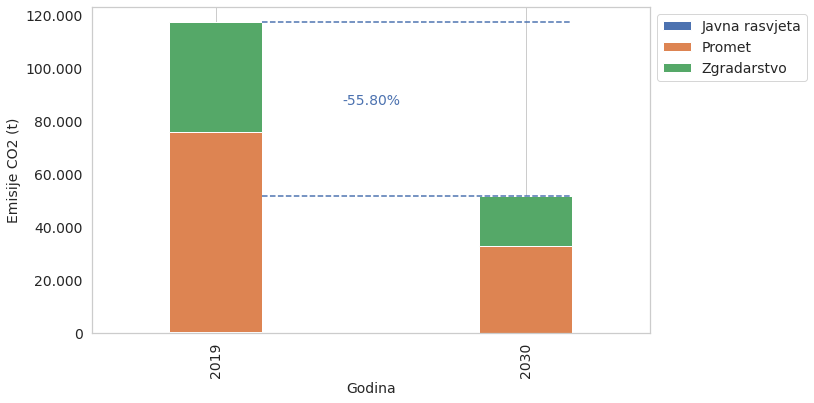

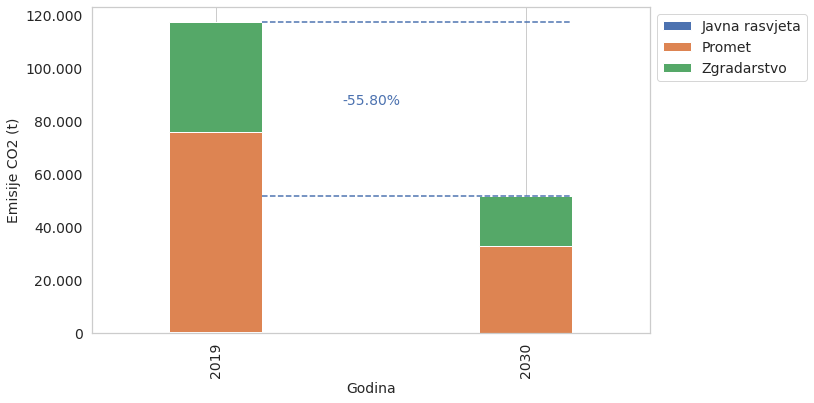

In [150]:
inventory_2030_co2_s2 = pd.Series(inventory_2030_s2[0].values, inventory_2030_s2['sektor']) * co2_2030_sector_scaling.values
inventory_2030_co2_s2 = inventory_2030_co2_s2.reset_index()
inventory_2030_co2_s2['Godina'] = 2030
projection_total = pd.concat([inventory_2019_total_co2, inventory_2030_co2_s2])
base_inventory_2019.projection_bar(projection_total, 'Emisije CO2 (t)')